In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
import pickle

In [2]:
preprocessed_file_path = ('/media/druv022/Data2/Better-Half/project/Colorectal_carcinoma/Colorectal_carcinoma/code/preprocessed_joined_df.csv')
patient_df = pd.read_csv(preprocessed_file_path)

patient_df.head().T

,0,1,2,3,4
SEX,0,1,1,0,0
HISTORY_OF_CANCER,0,0,0,1,0
VITAL_STATUS,1,1,1,0,1
OS_STATUS,1,1,1,0,1
DSS_STATUS,1,1,0,0,1
...,...,...,...,...,...
ICRSCORE,5.541343,4.817556,7.909826,6.577636,7.37415
MBR_SCORE,0.056723,0.070731,0.161886,-0.353789,0.327006
MICROSCORE,0.0,0.0,0.0,1.0,0.0
TMB_NONSYNONYMOUS,5.233333,2.766667,2.766667,2.433333,3.6


In [3]:
df_recur = patient_df[patient_df["PFS_STATUS_1:Recurred"] == True]
df_non_recur = patient_df[patient_df["PFS_STATUS_0:DiseaseFree"] == True]
print(f"Recurrence df: {df_recur.shape}, Non-recurrence df: {df_non_recur.shape}")

Recurrence df: (109, 90), Non-recurrence df: (239, 90)


In [4]:
df_recur["PFS_MONTHS"].sort_values().reset_index(drop=True)

0        0.16
1        0.72
2        0.79
3        1.02
4        1.02
        ...  
104     51.68
105     52.11
106     52.86
107     74.22
108    201.14
Name: PFS_MONTHS, Length: 109, dtype: float64

<Axes: >

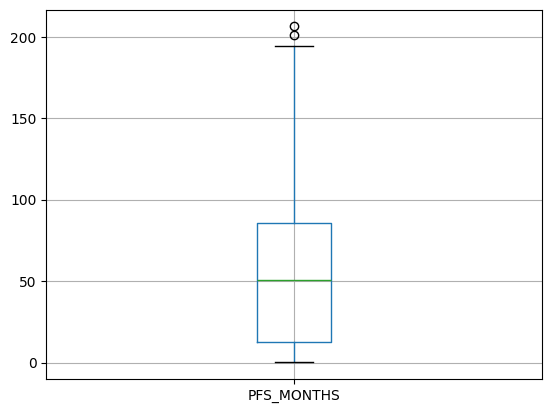

In [5]:
patient_df.boxplot(column = ["PFS_MONTHS"], grid = True)

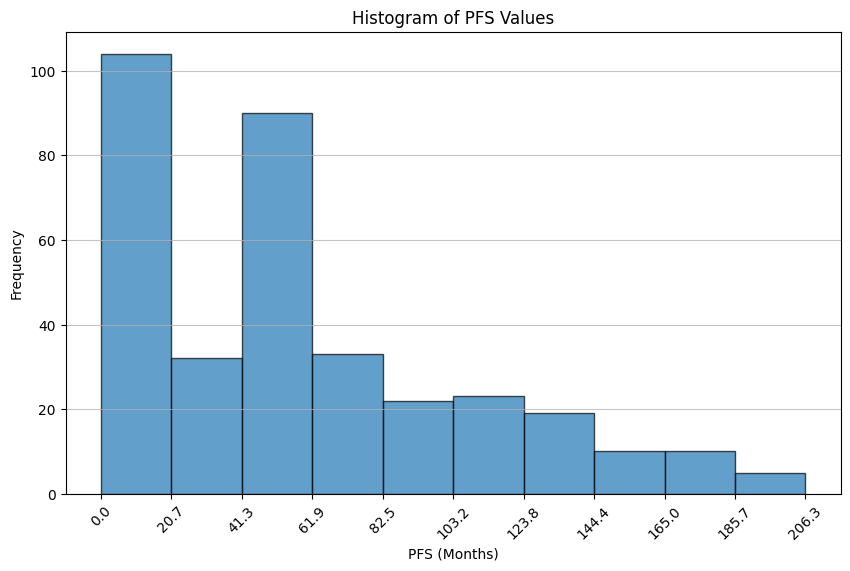

In [6]:
plt.figure(figsize=(10, 6))
plt.hist(patient_df['PFS_MONTHS'], bins=10, edgecolor='black', alpha=0.7)
plt.title('Histogram of PFS Values')
plt.xlabel('PFS (Months)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

# Define the number of bins
num_bins = 10

# Calculate the bin edges
bin_edges = np.linspace(patient_df['PFS_MONTHS'].min(), patient_df['PFS_MONTHS'].max(), num_bins + 1)

plt.xticks(bin_edges, rotation=45)

plt.show()

### Calculate the bin edges

In [7]:
def calculate_bin_edges(data, num_bins):
    # Sort the data
    sorted_data = np.sort(data)
    
    # Calculate the number of samples per bin
    samples_per_bin = len(sorted_data) // num_bins

    # Initialize an empty list for bin edges
    bin_edges = []

    # Determine the bin edges
    for i in range(num_bins):
        edge_value = sorted_data[i * samples_per_bin]
        bin_edges.append(edge_value)

    # Append the last value of the sorted data to the list of bin edges
    bin_edges.append(sorted_data[-1])

    # Plot the histogram
    plt.hist(data, bins=bin_edges, edgecolor='black')
    plt.title('Histogram with Bins')
    plt.xlabel('PFS Values')
    plt.ylabel('Frequency')
    plt.show()

    return bin_edges

### Assign class labels

In [8]:
def assign_class_labels(data, bin_edges):
    # Initialize an array to store class labels
    class_labels = np.zeros(len(data), dtype=int)

    # Assign class labels based on bin edges
    for i in range(len(bin_edges) - 1):
        class_labels[(data >= bin_edges[i]) & (data <= bin_edges[i + 1])] = i + 1
    
    return class_labels

In [9]:
dump_w21_inv_map_file = "w21_inv_map.pkl"

with open(dump_w21_inv_map_file, "rb") as f:
    w2i_inv_map = pickle.load(f)

### Splitting data to test-train

In [10]:
def split_data(data, labels, ratio):
    # Split the data and labels into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=(1 - ratio), random_state=42)
    x_test_results = pd.DataFrame(x_test)
    y_test_results = pd.DataFrame(y_test)
    print(x_test_results, y_test_results)
    return x_train, x_test, y_train, y_test

## Defining the classifiers

In [11]:
def define_classifiers(x_train, y_train, x_test, y_test): 
    classifiers = {
        "Logistic Regression": LogisticRegression(),
        "Decision Tree": DecisionTreeClassifier(),
        "Random Forest": RandomForestClassifier(random_state=55),
        "Support Vector Machine": SVC(),
        "K-Nearest Neighbors": KNeighborsClassifier(),
        "Naive Bayes": GaussianNB()
    }

    results = {"Classifer":[],
        "True_Labels": [],
        "Predicted_Labels": []}  # To store results for all classifiers

    # Train and evaluate classifiers
    for name, clf in classifiers.items():
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        print(f"Classifier: {name}")
        print(classification_report(y_test, y_pred))
        print("="*50)

        # store result
        test_df = pd.DataFrame(x_test, columns=patient_df.drop(columns=['PFS_MONTHS']).columns)
        test_df['True_Labels'] = y_test
        test_df['Predicted_Labels'] = y_pred
        
        # Append results to the list for further analysis or export
        for col in test_df.columns:
            if col in results:
                results[col].extend(test_df[col].values.tolist())
            else:
                results[col] = test_df[col].values.tolist()

        results["Classifer"].extend([name]*len(y_test))

    return pd.DataFrame(results)

In [12]:
def reverse_map(df, inv_map):
    for col in inv_map:
        df[col] = df[col].map(inv_map[col])

    return df

def save_results(df, file_name):
    df.to_csv(file_name)

## Experiment 1:
- number of bins = 4
- train |   test = 80%  |   20%

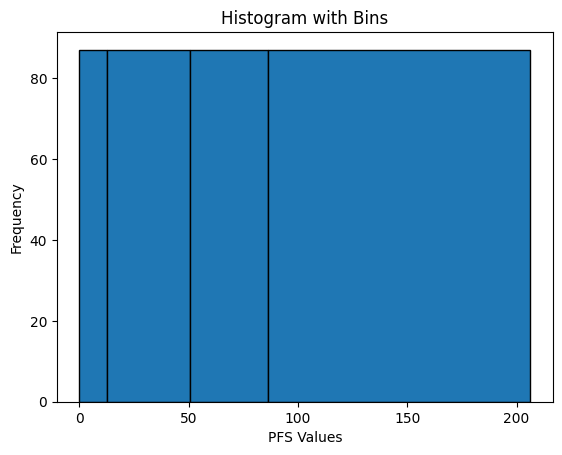

   0  1  2  3  4  5  6  7      8      9   ...   79   80  81      82      83  \
0   1  0  0  0  0  1  1  1  False  False  ...  0.0  0.0  66   58.19   58.19   
1   1  0  1  1  1  0  0  0  False   True  ...  2.0  1.0  60    3.81    3.81   
2   0  0  1  1  0  1  1  0   True  False  ...  0.0  0.0  76     4.8     4.8   
3   1  0  0  0  0  2  1  0  False  False  ...  0.0  0.0  86    52.4    52.4   
4   1  0  1  1  0  2  1  0   True  False  ...  0.0  0.0  78    4.86    4.86   
.. .. .. .. .. .. .. .. ..    ...    ...  ...  ...  ...  ..     ...     ...   
65  0  0  1  1  0  1  1  0  False  False  ...  0.0  0.0  70  113.71  113.71   
66  1  1  0  0  0  1  1  1   True  False  ...  1.0  0.0  69   83.68   83.68   
67  0  0  1  1  1  2  1  0  False   True  ...  2.0  0.0  86   22.28   22.28   
68  0  0  1  1  1  0  1  0  False  False  ...  1.0  1.0  57    5.29    5.29   
69  1  0  1  1  0  2  1  0   True  False  ...  0.0  0.0  83    38.6    0.13   

          84        85   86         87      88  
0 

In [13]:
# Extract the PFS (Progression-Free Survival) values
pfs_values = patient_df['PFS_MONTHS'].dropna().values
num_bins = 4  # Number of desired bins
bin_edges = calculate_bin_edges(pfs_values, num_bins)

# Assign class labels based on bin edges
class_labels = assign_class_labels(pfs_values, bin_edges)
class_label_map = {i:f"{bin_edges[i-1]} - {bin_edge}" for i,bin_edge in enumerate(bin_edges) if i != 0}

# add to mapping
w2i_inv_map['True_Labels'] = class_label_map
w2i_inv_map['Predicted_Labels'] = class_label_map

# Split data into features (X) and labels (y)
X = patient_df.drop(columns=['PFS_MONTHS']).values  # Assuming other features are in the DataFrame
y = class_labels

# Split data into training and testing sets
ratio = 0.8  # 80% training data, 20% testing data
x_train, x_test, y_train, y_test = split_data(X, y, ratio)

print("Training features shape:", x_train.shape)
print("Testing features shape:", x_test.shape)
print("Training labels shape:", y_train.shape)
print("Testing labels shape:", y_test.shape)

In [14]:
results_df = define_classifiers(x_train, y_train, x_test, y_test)

Classifier: Logistic Regression
              precision    recall  f1-score   support

           1       0.54      0.88      0.67        16
           2       0.67      0.32      0.43        19
           3       0.67      0.62      0.64        13
           4       0.96      1.00      0.98        22

    accuracy                           0.71        70
   macro avg       0.71      0.70      0.68        70
weighted avg       0.73      0.71      0.69        70

Classifier: Decision Tree
              precision    recall  f1-score   support

           1       0.64      0.88      0.74        16
           2       0.85      0.58      0.69        19
           3       1.00      1.00      1.00        13
           4       1.00      1.00      1.00        22

    accuracy                           0.86        70
   macro avg       0.87      0.86      0.86        70
weighted avg       0.88      0.86      0.86        70

Classifier: Random Forest
              precision    recall  f1-score   

/home/druv022/miniconda3/envs/test/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classifier: K-Nearest Neighbors
              precision    recall  f1-score   support

           1       0.50      0.75      0.60        16
           2       0.69      0.47      0.56        19
           3       0.58      0.54      0.56        13
           4       0.90      0.86      0.88        22

    accuracy                           0.67        70
   macro avg       0.67      0.66      0.65        70
weighted avg       0.69      0.67      0.67        70

Classifier: Naive Bayes
              precision    recall  f1-score   support

           1       0.52      0.75      0.62        16
           2       0.25      0.05      0.09        19
           3       0.50      0.23      0.32        13
           4       0.51      0.86      0.64        22

    accuracy                           0.50        70
   macro avg       0.45      0.47      0.42        70
weighted avg       0.44      0.50      0.43        70



In [15]:
results_df = reverse_map(results_df, w2i_inv_map)

save_results(results_df, "EXP01_results.csv")

## Experiment 2
- Number of bins = 3
- train |   test = 80%  |   20%

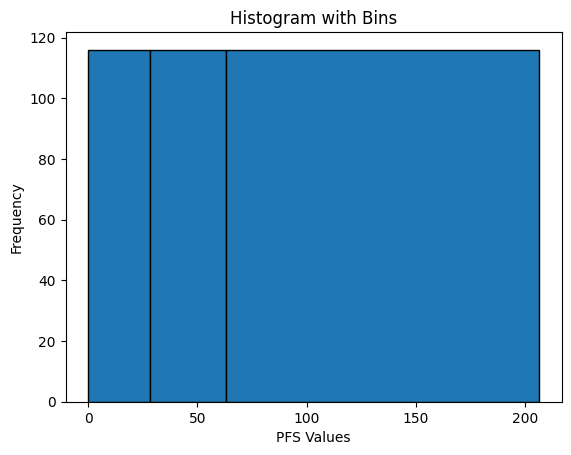

   0  1  2  3  4  5  6  7      8      9   ...   79   80  81      82      83  \
0   1  0  0  0  0  1  1  1  False  False  ...  0.0  0.0  66   58.19   58.19   
1   1  0  1  1  1  0  0  0  False   True  ...  2.0  1.0  60    3.81    3.81   
2   0  0  1  1  0  1  1  0   True  False  ...  0.0  0.0  76     4.8     4.8   
3   1  0  0  0  0  2  1  0  False  False  ...  0.0  0.0  86    52.4    52.4   
4   1  0  1  1  0  2  1  0   True  False  ...  0.0  0.0  78    4.86    4.86   
.. .. .. .. .. .. .. .. ..    ...    ...  ...  ...  ...  ..     ...     ...   
65  0  0  1  1  0  1  1  0  False  False  ...  0.0  0.0  70  113.71  113.71   
66  1  1  0  0  0  1  1  1   True  False  ...  1.0  0.0  69   83.68   83.68   
67  0  0  1  1  1  2  1  0  False   True  ...  2.0  0.0  86   22.28   22.28   
68  0  0  1  1  1  0  1  0  False  False  ...  1.0  1.0  57    5.29    5.29   
69  1  0  1  1  0  2  1  0   True  False  ...  0.0  0.0  83    38.6    0.13   

          84        85   86         87      88  
0 

In [16]:
# Extract the PFS (Progression-Free Survival) values
pfs_values = patient_df['PFS_MONTHS'].dropna().values
num_bins = 3  # Number of desired bins
bin_edges = calculate_bin_edges(pfs_values, num_bins)

# Assign class labels based on bin edges
class_labels = assign_class_labels(pfs_values, bin_edges)
class_label_map = {i:f"{bin_edges[i-1]} - {bin_edge}" for i,bin_edge in enumerate(bin_edges) if i != 0}

# add to mapping
w2i_inv_map['True_Labels'] = class_label_map
w2i_inv_map['Predicted_Labels'] = class_label_map

# Split data into features (X) and labels (y)
X = patient_df.drop(columns=['PFS_MONTHS']).values  # Assuming other features are in the DataFrame
y = class_labels

# Split data into training and testing sets
ratio = 0.8  # 80% training data, 20% testing data
x_train, x_test, y_train, y_test = split_data(X, y, ratio)

print("Training features shape:", x_train.shape)
print("Testing features shape:", x_test.shape)
print("Training labels shape:", y_train.shape)
print("Testing labels shape:", y_test.shape)

In [17]:
results_df = define_classifiers(x_train, y_train, x_test, y_test)

Classifier: Logistic Regression
              precision    recall  f1-score   support

           1       0.88      0.88      0.88        25
           2       0.74      0.78      0.76        18
           3       0.92      0.89      0.91        27

    accuracy                           0.86        70
   macro avg       0.85      0.85      0.85        70
weighted avg       0.86      0.86      0.86        70

Classifier: Decision Tree
              precision    recall  f1-score   support

           1       0.96      0.88      0.92        25
           2       0.81      0.94      0.87        18
           3       1.00      0.96      0.98        27

    accuracy                           0.93        70
   macro avg       0.92      0.93      0.92        70
weighted avg       0.94      0.93      0.93        70

Classifier: Random Forest
              precision    recall  f1-score   support

           1       0.89      1.00      0.94        25
           2       1.00      0.89      0.94  

/home/druv022/miniconda3/envs/test/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [18]:
results_df = reverse_map(results_df, w2i_inv_map)

save_results(results_df, "EXP02_results.csv")

## Experiment 3
- Number of bins = 6
- train |   test = 80%  |   20%

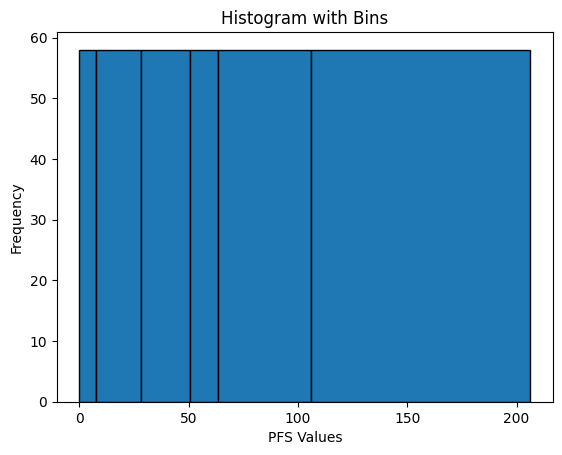

   0  1  2  3  4  5  6  7      8      9   ...   79   80  81      82      83  \
0   1  0  0  0  0  1  1  1  False  False  ...  0.0  0.0  66   58.19   58.19   
1   1  0  1  1  1  0  0  0  False   True  ...  2.0  1.0  60    3.81    3.81   
2   0  0  1  1  0  1  1  0   True  False  ...  0.0  0.0  76     4.8     4.8   
3   1  0  0  0  0  2  1  0  False  False  ...  0.0  0.0  86    52.4    52.4   
4   1  0  1  1  0  2  1  0   True  False  ...  0.0  0.0  78    4.86    4.86   
.. .. .. .. .. .. .. .. ..    ...    ...  ...  ...  ...  ..     ...     ...   
65  0  0  1  1  0  1  1  0  False  False  ...  0.0  0.0  70  113.71  113.71   
66  1  1  0  0  0  1  1  1   True  False  ...  1.0  0.0  69   83.68   83.68   
67  0  0  1  1  1  2  1  0  False   True  ...  2.0  0.0  86   22.28   22.28   
68  0  0  1  1  1  0  1  0  False  False  ...  1.0  1.0  57    5.29    5.29   
69  1  0  1  1  0  2  1  0   True  False  ...  0.0  0.0  83    38.6    0.13   

          84        85   86         87      88  
0 

In [19]:
# Extract the PFS (Progression-Free Survival) values
pfs_values = patient_df['PFS_MONTHS'].dropna().values
num_bins = 6  # Number of desired bins
bin_edges = calculate_bin_edges(pfs_values, num_bins)

# Assign class labels based on bin edges////
class_labels = assign_class_labels(pfs_values, bin_edges)
class_label_map = {i:f"{bin_edges[i-1]} - {bin_edge}" for i,bin_edge in enumerate(bin_edges) if i != 0}

# add to mapping
w2i_inv_map['True_Labels'] = class_label_map
w2i_inv_map['Predicted_Labels'] = class_label_map

# Split data into features (X) and labels (y)
X = patient_df.drop(columns=['PFS_MONTHS']).values  # Assuming other features are in the DataFrame
y = class_labels

# Split data into training and testing sets
ratio = 0.8  # 80% training data, 20% testing data
x_train, x_test, y_train, y_test = split_data(X, y, ratio)

print("Training features shape:", x_train.shape)
print("Testing features shape:", x_test.shape)
print("Training labels shape:", y_train.shape)
print("Testing labels shape:", y_test.shape)

In [20]:
results_df = define_classifiers(x_train, y_train, x_test, y_test)

Classifier: Logistic Regression
              precision    recall  f1-score   support

           1       0.53      0.91      0.67        11
           2       0.22      0.14      0.17        14
           3       0.67      0.40      0.50        10
           4       0.56      0.62      0.59         8
           5       0.62      0.50      0.56        10
           6       0.89      1.00      0.94        17

    accuracy                           0.61        70
   macro avg       0.58      0.60      0.57        70
weighted avg       0.59      0.61      0.59        70

Classifier: Decision Tree
              precision    recall  f1-score   support

           1       0.59      0.91      0.71        11
           2       0.78      0.50      0.61        14
           3       1.00      0.90      0.95        10
           4       0.89      1.00      0.94         8
           5       1.00      0.90      0.95        10
           6       1.00      1.00      1.00        17

    accuracy       

/home/druv022/miniconda3/envs/test/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [21]:
results_df = reverse_map(results_df, w2i_inv_map)

save_results(results_df, "EXP03_results.csv")